In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import the library to mount Google Drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Define monkey ID and file paths
monkey_id = "MonkeyN"  # or "MonkeyF"
FOLDERNAME = 'ML_project'
FILENAME = f'{monkey_id}_MUA_responses.csv'  # Automatically picks based on monkey


%cd drive/My\ Drive
%cp -r $FOLDERNAME/$FILENAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


#Data display

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the CSV file
csv_path = f"/content/{monkey_id}_MUA_responses.csv"  # Ensure the file is in the correct location
df = pd.read_csv(csv_path)

# Show the first few rows
print("\nFirst 5 Rows of the Data:")
display(df.head())

# Dataset summary
print("\nDataset Information:")
display(df.info())

# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"\nTotal Missing Values in Dataset: {missing_values}")


First 5 Rows of the Data:


,Stimulus_Name,Class,Trial_Type,Electrode_1_Region,Electrode_1,Electrode_2_Region,Electrode_2,Electrode_3_Region,Electrode_3,Electrode_4_Region,...,Electrode_1021_Region,Electrode_1021,Electrode_1022_Region,Electrode_1022,Electrode_1023_Region,Electrode_1023,Electrode_1024_Region,Electrode_1024,cr,category_label
0,aardvark/aardvark_01b.jpg,aardvark,train,V1,0.197251,V1,-0.363297,V1,-0.174299,V1,...,IT,0.474470,IT,0.511270,IT,0.598430,IT,-0.170771,0.825000,animal
1,aardvark/aardvark_02s.jpg,aardvark,train,V1,0.098914,V1,-0.334109,V1,-0.174991,V1,...,IT,0.187520,IT,0.194848,IT,0.254685,IT,0.133497,0.800000,animal
2,aardvark/aardvark_03s.jpg,aardvark,train,V1,0.434298,V1,0.020933,V1,-0.221039,V1,...,IT,0.272528,IT,0.742424,IT,0.205106,IT,0.398020,0.878049,animal
3,aardvark/aardvark_04s.jpg,aardvark,train,V1,-0.035596,V1,-0.360433,V1,-0.116870,V1,...,IT,1.373205,IT,1.121719,IT,0.993495,IT,0.239756,0.731707,animal
4,aardvark/aardvark_05s.jpg,aardvark,train,V1,0.469175,V1,0.058533,V1,-0.001665,V1,...,IT,-0.120017,IT,-0.003335,IT,0.590054,IT,-0.065705,0.825000,animal



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22348 entries, 0 to 22347
Columns: 2053 entries, Stimulus_Name to category_label
dtypes: float64(1025), object(1028)
memory usage: 350.0+ MB


None


Total Missing Values in Dataset: 6387


In [ ]:
# Extract electrode columns
electrode_cols = [col for col in df.columns if "Electrode_" in col and "Region" not in col]

# Compute mean response across all electrodes for each stimulus
df["Mean_Response_All_Electrodes"] = df[electrode_cols].mean(axis=1)

# Compute mean response per region (V1, V4, IT)
region_means = {}
for region in ["V1", "V4", "IT"]:
    region_cols = [col for col in electrode_cols if df.loc[df.index[0], col.replace("Electrode_", "Electrode_") + "_Region"] == region]
    if region_cols:
        df[f"Mean_Response_{region}"] = df[region_cols].mean(axis=1)
    else:
        df[f"Mean_Response_{region}"] = np.nan  # Assign NaN if no columns exist

# Show the first few rows with computed mean responses
print("\nFirst 5 Rows with Mean Responses per Region:")
display(df[["Stimulus_Name", "Class", "category_label", "Mean_Response_All_Electrodes", "Mean_Response_V1", "Mean_Response_V4", "Mean_Response_IT"]])

# Keep only rows with non-missing category label
df = df[df['category_label'].notna()].reset_index(drop=True)
display(df[["Stimulus_Name", "Class", "category_label", "Mean_Response_All_Electrodes", "Mean_Response_V1", "Mean_Response_V4", "Mean_Response_IT"]])



First 5 Rows with Mean Responses per Region:


,Stimulus_Name,Class,category_label,Mean_Response_All_Electrodes,Mean_Response_V1,Mean_Response_V4,Mean_Response_IT
0,aardvark/aardvark_01b.jpg,aardvark,animal,-0.149905,-0.409440,-0.041298,0.260560
1,aardvark/aardvark_02s.jpg,aardvark,animal,-0.025621,-0.218781,0.048397,0.286680
2,aardvark/aardvark_03s.jpg,aardvark,animal,0.256926,0.119111,0.336028,0.453453
3,aardvark/aardvark_04s.jpg,aardvark,animal,0.098076,-0.220683,0.089439,0.744232
4,aardvark/aardvark_05s.jpg,aardvark,animal,0.149107,0.137091,0.241802,0.080444
...,...,...,...,...,...,...,...
22343,wallpaper/wallpaper_13s.jpg,wallpaper,home decor,-0.154046,-0.187677,-0.094387,-0.146442
22344,wasp/wasp_15n.jpg,wasp,animal,-0.116922,-0.144054,-0.104578,-0.075003
22345,watch/watch_13s.jpg,watch,clothing accessory,0.179471,0.219321,0.097807,0.181435
22346,whip/whip_14s.jpg,whip,weapon,0.043417,0.122365,0.019786,-0.090850


,Stimulus_Name,Class,category_label,Mean_Response_All_Electrodes,Mean_Response_V1,Mean_Response_V4,Mean_Response_IT
0,aardvark/aardvark_01b.jpg,aardvark,animal,-0.149905,-0.409440,-0.041298,0.260560
1,aardvark/aardvark_02s.jpg,aardvark,animal,-0.025621,-0.218781,0.048397,0.286680
2,aardvark/aardvark_03s.jpg,aardvark,animal,0.256926,0.119111,0.336028,0.453453
3,aardvark/aardvark_04s.jpg,aardvark,animal,0.098076,-0.220683,0.089439,0.744232
4,aardvark/aardvark_05s.jpg,aardvark,animal,0.149107,0.137091,0.241802,0.080444
...,...,...,...,...,...,...,...
15957,uniform/uniform_14s.jpg,uniform,clothing,0.108529,0.093563,0.203324,0.043665
15958,wallpaper/wallpaper_13s.jpg,wallpaper,home decor,-0.154046,-0.187677,-0.094387,-0.146442
15959,wasp/wasp_15n.jpg,wasp,animal,-0.116922,-0.144054,-0.104578,-0.075003
15960,watch/watch_13s.jpg,watch,clothing accessory,0.179471,0.219321,0.097807,0.181435


#SVC + MLP

In [ ]:
import pandas as pd
import numpy as np

# Drop rows with missing values
df_clean = df.dropna(subset=['cr', 'category_label']).copy()

# Bin cr into 10 equal-width bins from 0.0 to 1.0
bins = [i / 10 for i in range(11)]  # [0.0, 0.1, ..., 1.0]
labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(10)]
df_clean['mem_bin'] = pd.cut(df_clean['cr'], bins=bins, labels=labels, include_lowest=True)

# Count and filter bins with enough data
bin_counts = df_clean['mem_bin'].value_counts().sort_index()
print("Bin sizes:\n", bin_counts)

min_samples_required = 50
valid_bins = bin_counts[bin_counts >= min_samples_required].index

# Keep only valid bins and drop duplicate stimuli
stimulus_df = df_clean[df_clean['mem_bin'].isin(valid_bins)].drop_duplicates(subset=['Stimulus_Name'])

# Balance the bins using unique stimuli
filtered_bin_counts = stimulus_df['mem_bin'].value_counts().sort_index()
filtered_bin_counts = filtered_bin_counts[filtered_bin_counts > 0]  # Filter out empty bins
min_bin_size = filtered_bin_counts.min()
print("\nFiltered bin sizes:\n", filtered_bin_counts)
print(f"\nBalancing to {min_bin_size} stimuli per bin...")


balanced_stimuli = (
    stimulus_df.groupby('mem_bin', group_keys=False, observed=True)
    .sample(n=min_bin_size, random_state=42)
)

# Step 6: Get all rows for selected stimuli
df_balanced = df_clean[df_clean['Stimulus_Name'].isin(balanced_stimuli['Stimulus_Name'])].copy()
print("\nFinal balanced bin sizes:")
print(df_balanced['mem_bin'].value_counts().sort_index())

# Create binary memorability class based on median
threshold = df_balanced['cr'].median()
print(f"\nBinary classification threshold (median cr): {threshold:.3f}")
df_balanced['memorability_class'] = (df_balanced['cr'] > threshold).astype(int)
print("\nBinary class distribution:")
print(df_balanced['memorability_class'].value_counts())

# Extract ROI regions
roi_regions = {
    region: [col for col in df.columns if col.startswith("Electrode_") and not col.endswith("_Region")
             and df.loc[0, col + "_Region"] == region]
    for region in ["V1", "V4", "IT"]
}

# Prepare ROI data
roi_data = {}
for roi, electrodes in roi_regions.items():
    sub_df = df_balanced.dropna(subset=electrodes + ['mem_bin']).drop_duplicates(subset=['Stimulus_Name'])
    X = sub_df[electrodes].values
    y = sub_df['mem_bin'].astype(str).values  # Use string bin labels (e.g., "0.7–0.8")
    roi_data[roi] = {'X': X, 'y': y}
    print(f"{roi}: {X.shape[0]} samples, {X.shape[1]} electrodes")


display(df_balanced)


Bin sizes:
 mem_bin
0.0–0.1       0
0.1–0.2       0
0.2–0.3       0
0.3–0.4       0
0.4–0.5      34
0.5–0.6     263
0.6–0.7    1880
0.7–0.8    6160
0.8–0.9    6427
0.9–1.0    1197
Name: count, dtype: int64

Filtered bin sizes:
 mem_bin
0.5–0.6     263
0.6–0.7    1880
0.7–0.8    6160
0.8–0.9    6427
0.9–1.0    1197
Name: count, dtype: int64

Balancing to 263 stimuli per bin...

Final balanced bin sizes:
mem_bin
0.0–0.1      0
0.1–0.2      0
0.2–0.3      0
0.3–0.4      0
0.4–0.5      0
0.5–0.6    263
0.6–0.7    263
0.7–0.8    263
0.8–0.9    263
0.9–1.0    263
Name: count, dtype: int64

Binary classification threshold (median cr): 0.769

Binary class distribution:
memorability_class
0    666
1    649
Name: count, dtype: int64
V1: 1315 samples, 512 electrodes
V4: 1315 samples, 256 electrodes
IT: 1315 samples, 256 electrodes


,Stimulus_Name,Class,Trial_Type,Electrode_1_Region,Electrode_1,Electrode_2_Region,Electrode_2,Electrode_3_Region,Electrode_3,Electrode_4_Region,...,Electrode_1024_Region,Electrode_1024,cr,category_label,Mean_Response_All_Electrodes,Mean_Response_V1,Mean_Response_V4,Mean_Response_IT,mem_bin,memorability_class
10,aardvark/aardvark_11s.jpg,aardvark,train,V1,0.402371,V1,0.299265,V1,0.189733,V1,...,IT,0.404979,0.815789,animal,0.313076,0.172538,0.372573,0.534655,0.8–0.9,1
19,abacus/abacus_08s.jpg,abacus,train,V1,0.067135,V1,0.232354,V1,-0.105099,V1,...,IT,-0.010095,0.756098,home decor,-0.009622,0.124240,0.026994,-0.313962,0.7–0.8,0
39,air_conditioner/air_conditioner_04s.jpg,air_conditioner,train,V1,-0.062361,V1,0.026980,V1,-0.578808,V1,...,IT,0.492561,0.775000,electronic device,-0.012930,0.114308,-0.096766,-0.183571,0.7–0.8,1
44,air_conditioner/air_conditioner_09s.jpg,air_conditioner,train,V1,-0.085950,V1,0.083480,V1,0.554767,V1,...,IT,-0.349980,0.767442,electronic device,-0.034850,0.048386,-0.114944,-0.121228,0.7–0.8,0
45,air_conditioner/air_conditioner_10s.jpg,air_conditioner,train,V1,-0.355756,V1,-0.358919,V1,-0.713832,V1,...,IT,-0.146541,0.897436,electronic device,0.060564,0.112538,-0.062232,0.079412,0.8–0.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15874,zebra/zebra_11s.jpg,zebra,train,V1,0.335780,V1,0.830658,V1,0.312196,V1,...,IT,-0.254886,0.794872,animal,0.156035,0.254599,0.068039,0.046901,0.7–0.8,1
15875,zebra/zebra_12s.jpg,zebra,train,V1,0.152406,V1,1.137057,V1,0.651189,V1,...,IT,-0.146485,0.868421,animal,0.345405,0.358549,0.215905,0.448616,0.8–0.9,1
15890,axe/axe_14n.jpg,axe,test,V1,0.029329,V1,-0.322478,V1,-0.290539,V1,...,IT,0.104689,0.829268,tool,0.017312,0.014266,-0.005853,0.046569,0.8–0.9,1
15899,bike/bike_14s.jpg,bike,test,V1,0.267251,V1,0.593505,V1,0.716529,V1,...,IT,-0.044760,0.552632,vehicle,0.125467,0.172503,0.197140,-0.040277,0.5–0.6,0



==== Processing ROI: V1 ====
Using fixed SVC parameters for ROI: V1 ...

[V1 | SVC] Model Performance:
Accuracy Score: 0.5019011406844106
Precision Score: 0.48
F1 Score: 0.15483870967741936
ROC AUC: 0.5174089068825911


<ipython-input-11-35c36c347725>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
<ipython-input-11-35c36c347725>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')


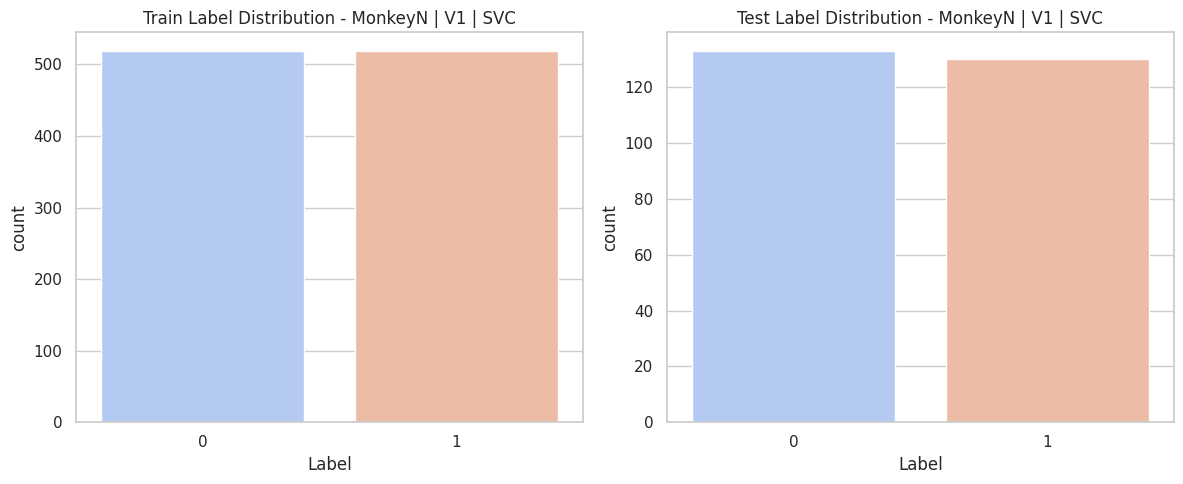

<ipython-input-11-35c36c347725>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
<ipython-input-11-35c36c347725>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')


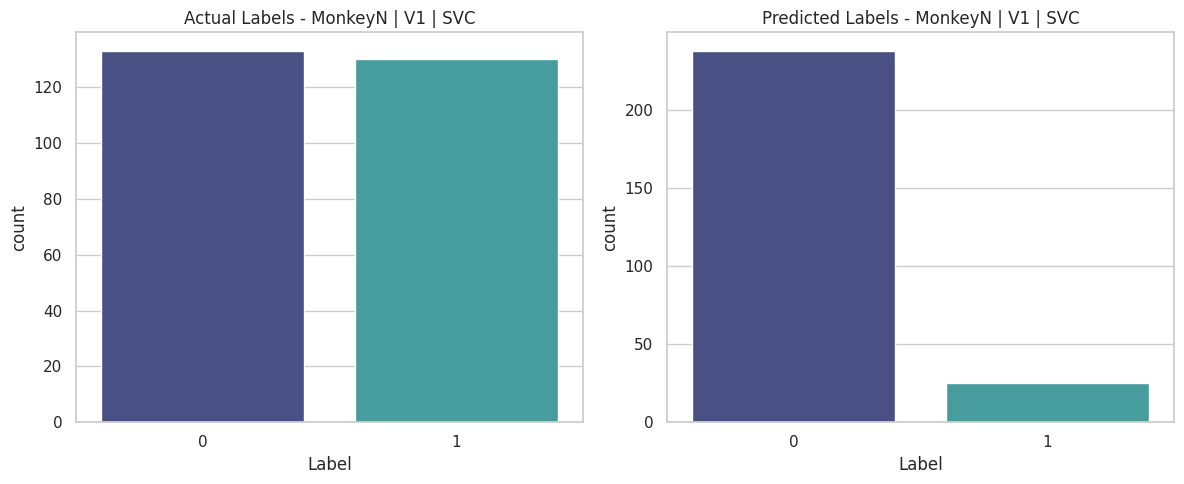

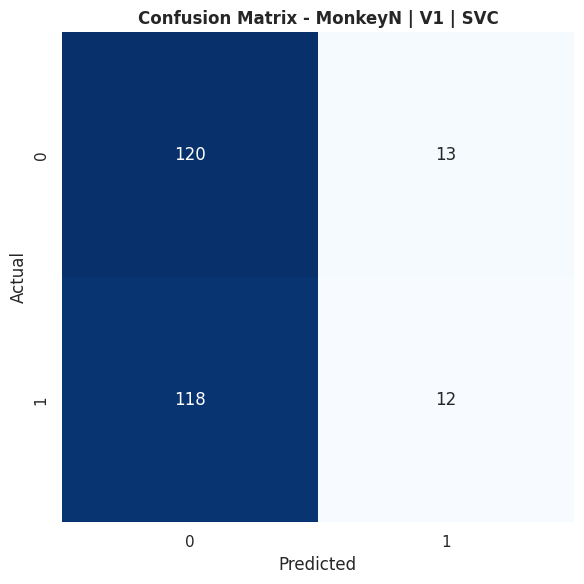

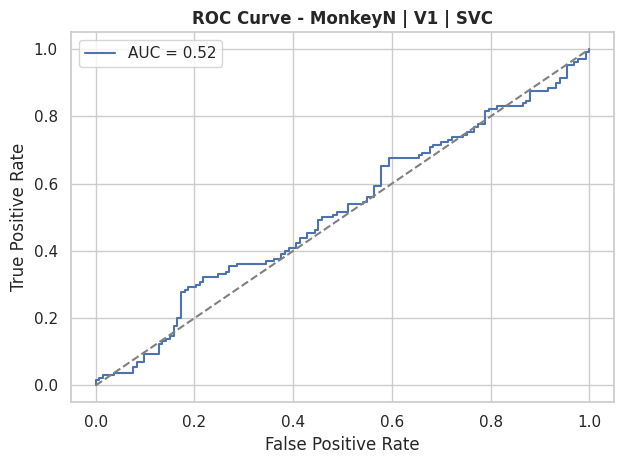


Training MLPClassifier for ROI: V1 ...

[V1 | MLP] Model Performance:
Accuracy Score: 0.5627376425855514
Precision Score: 0.5572519083969466
F1 Score: 0.5593869731800766
ROC AUC: 0.5632157316367842


<ipython-input-11-35c36c347725>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
<ipython-input-11-35c36c347725>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')


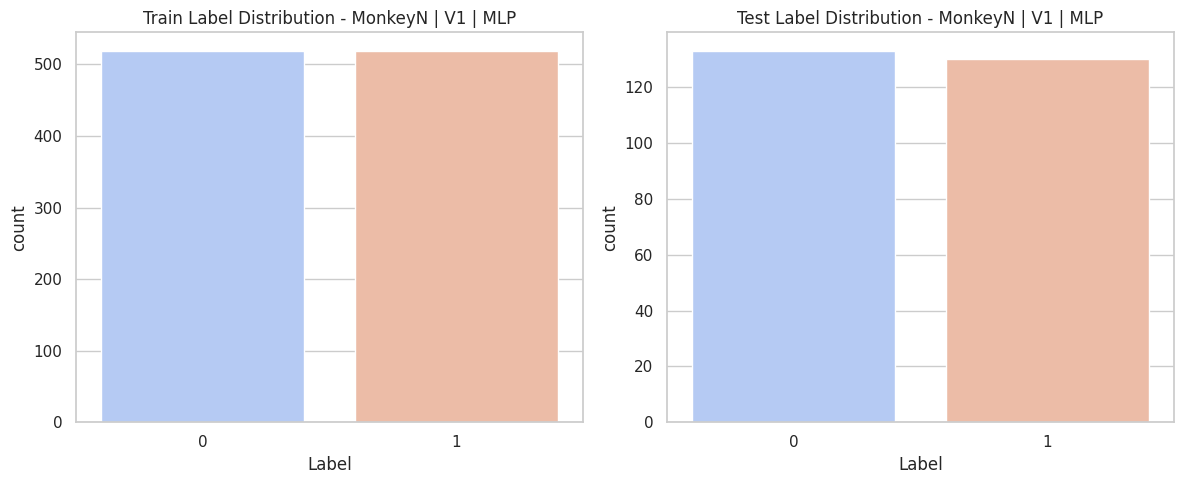

<ipython-input-11-35c36c347725>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
<ipython-input-11-35c36c347725>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')


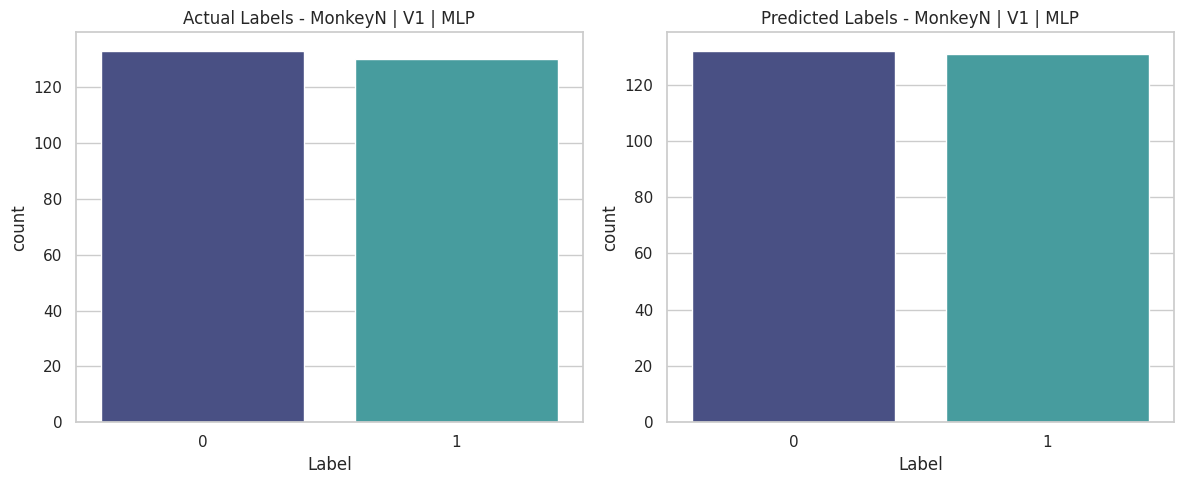

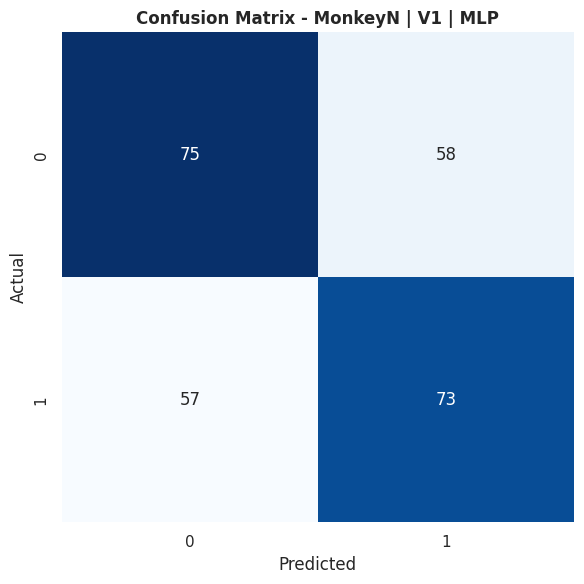

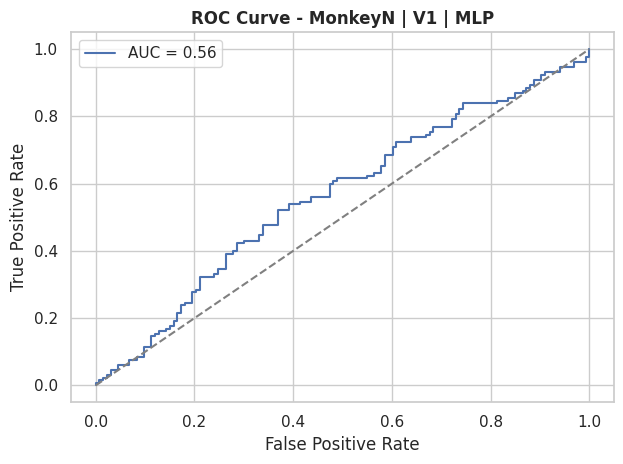

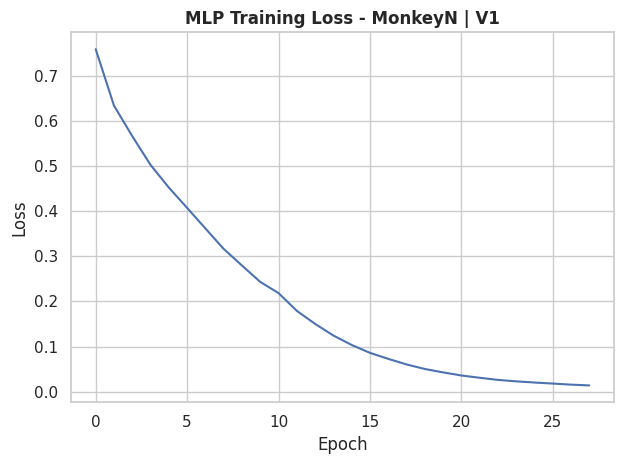


==== Processing ROI: V4 ====
Using fixed SVC parameters for ROI: V4 ...

[V4 | SVC] Model Performance:
Accuracy Score: 0.5057034220532319
Precision Score: 0.5
F1 Score: 0.09722222222222222
ROC AUC: 0.5433776749566224


<ipython-input-11-35c36c347725>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
<ipython-input-11-35c36c347725>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')


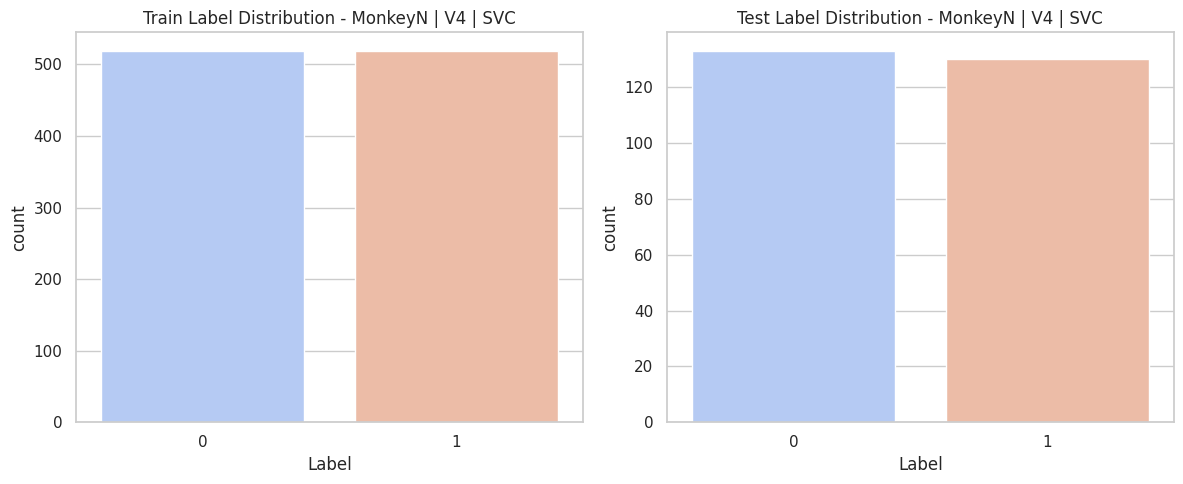

<ipython-input-11-35c36c347725>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
<ipython-input-11-35c36c347725>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')


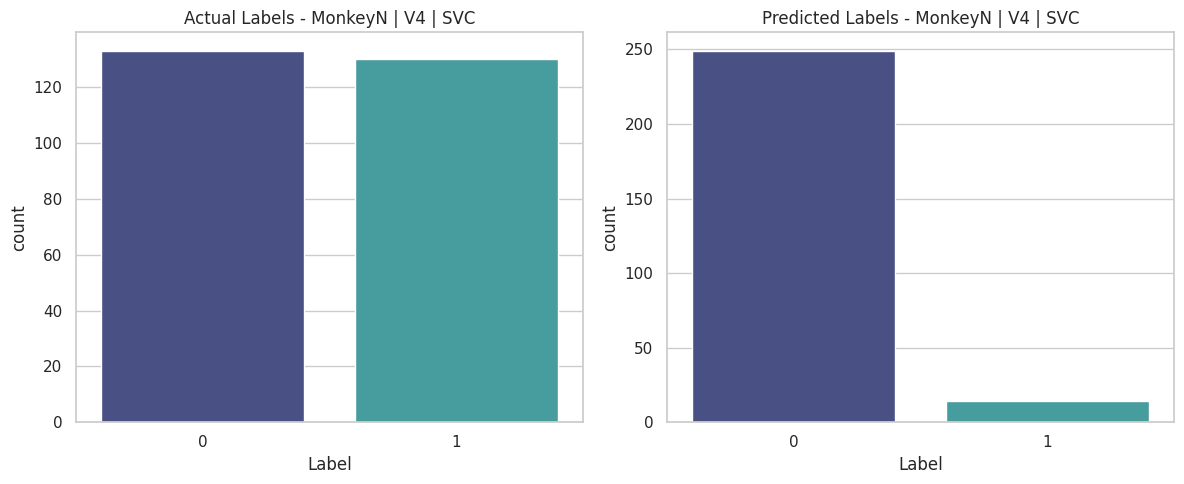

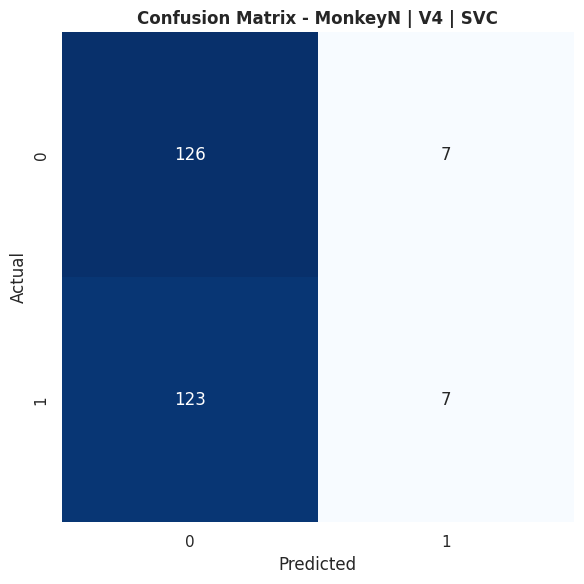

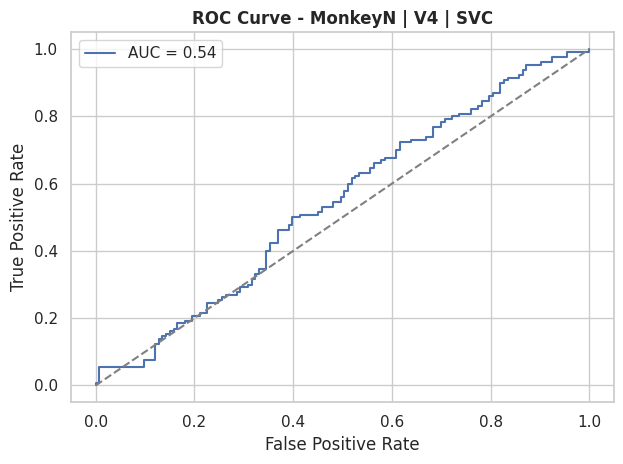


Training MLPClassifier for ROI: V4 ...

[V4 | MLP] Model Performance:
Accuracy Score: 0.5741444866920152
Precision Score: 0.5692307692307692
F1 Score: 0.5692307692307692
ROC AUC: 0.5931752458068248


<ipython-input-11-35c36c347725>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
<ipython-input-11-35c36c347725>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')


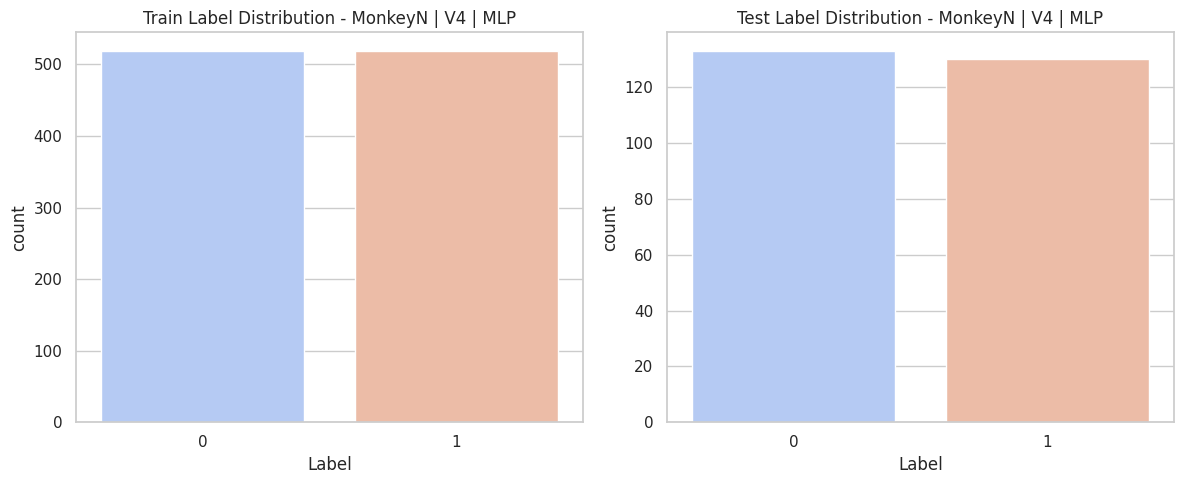

<ipython-input-11-35c36c347725>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
<ipython-input-11-35c36c347725>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')


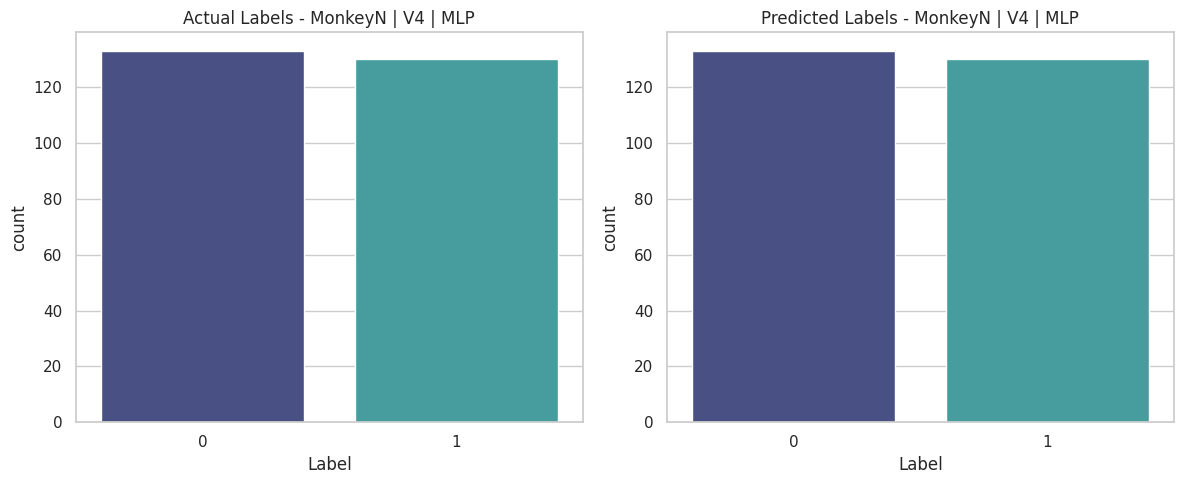

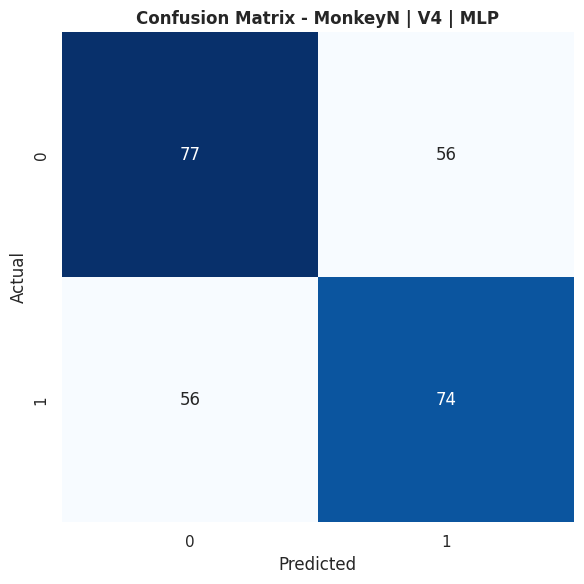

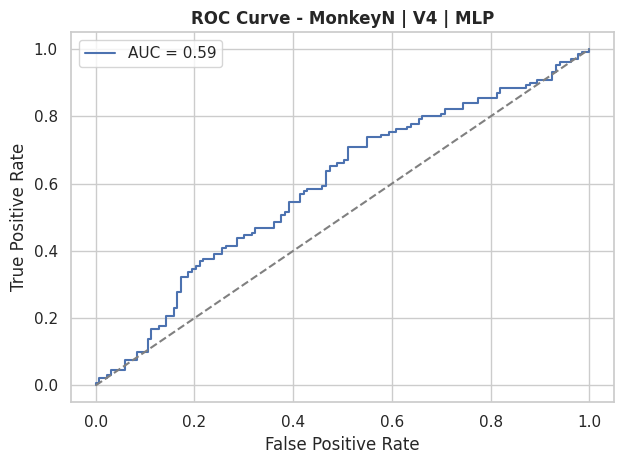

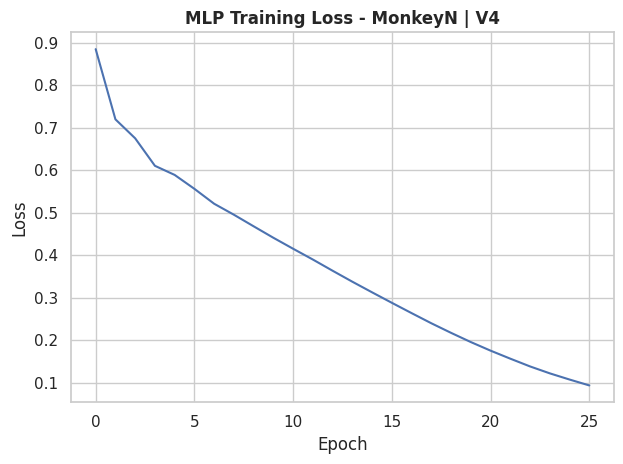


==== Processing ROI: IT ====
Using fixed SVC parameters for ROI: IT ...

[IT | SVC] Model Performance:
Accuracy Score: 0.4790874524714829
Precision Score: 0.48616600790513836
F1 Score: 0.6422976501305483
ROC AUC: 0.5065934065934066


<ipython-input-11-35c36c347725>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
<ipython-input-11-35c36c347725>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')


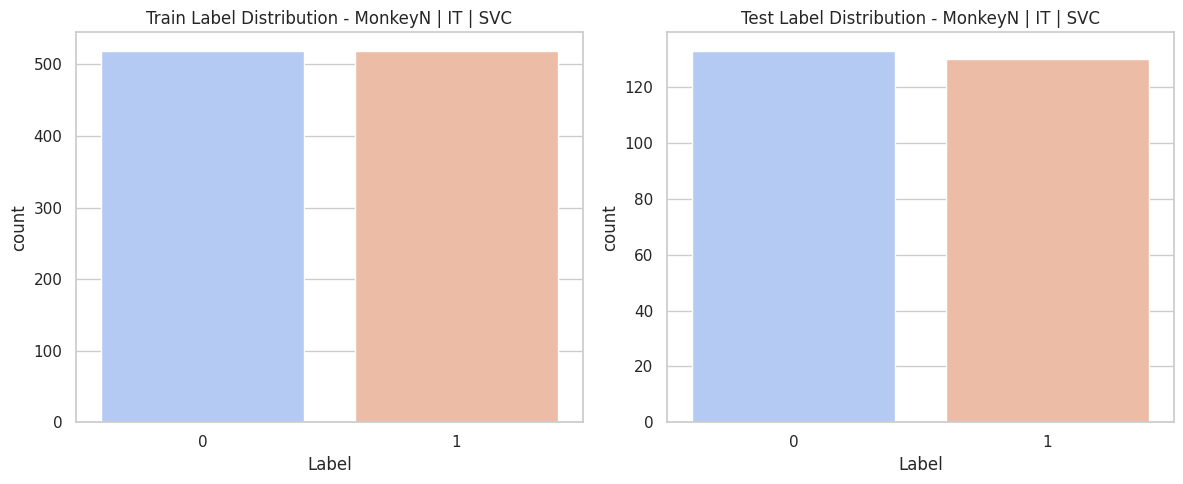

<ipython-input-11-35c36c347725>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
<ipython-input-11-35c36c347725>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')


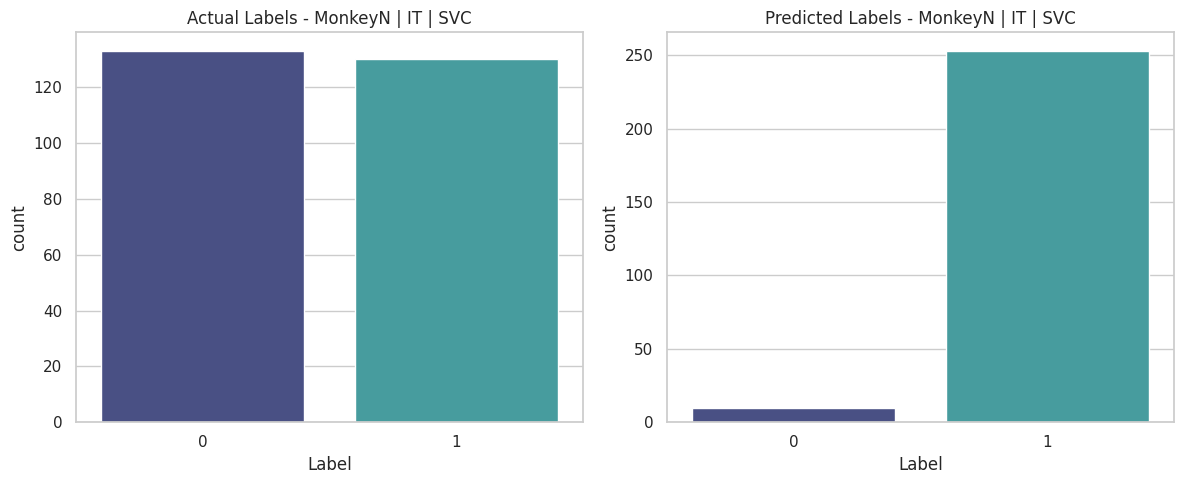

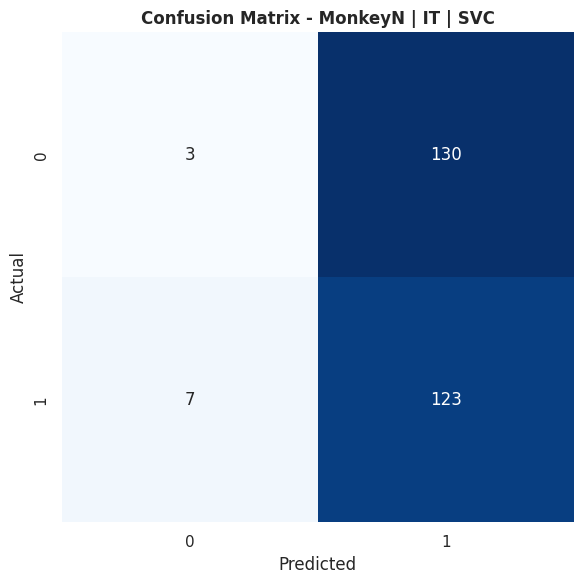

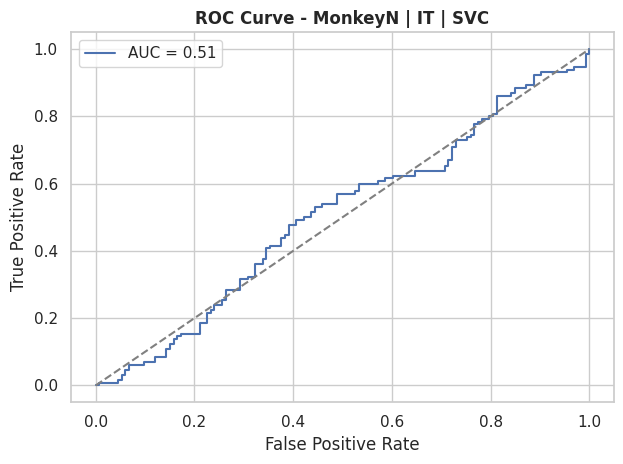


Training MLPClassifier for ROI: IT ...

[IT | MLP] Model Performance:
Accuracy Score: 0.5893536121673004
Precision Score: 0.5774647887323944
F1 Score: 0.6029411764705882
ROC AUC: 0.5991324465008675


<ipython-input-11-35c36c347725>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
<ipython-input-11-35c36c347725>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')


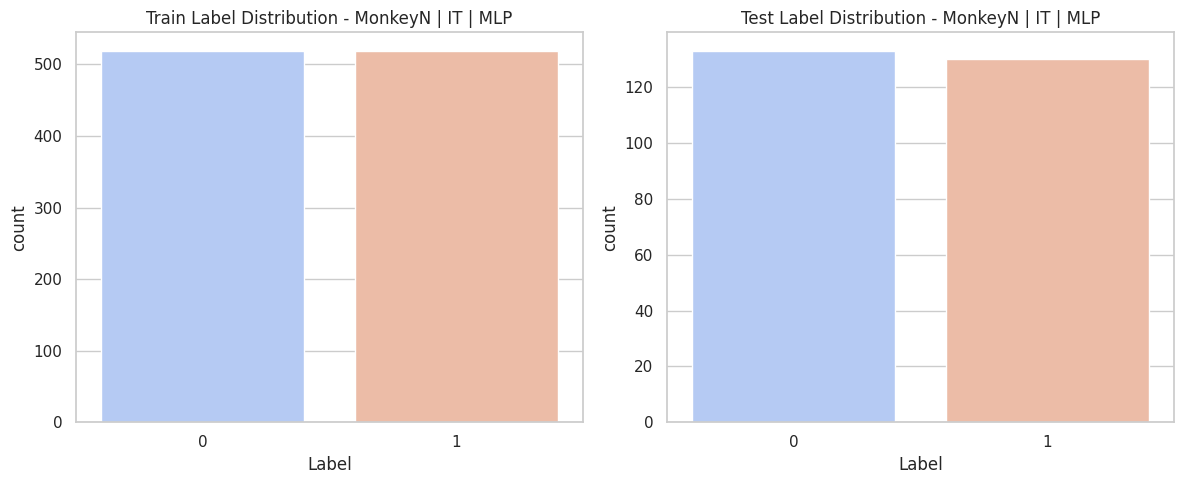

<ipython-input-11-35c36c347725>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
<ipython-input-11-35c36c347725>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')


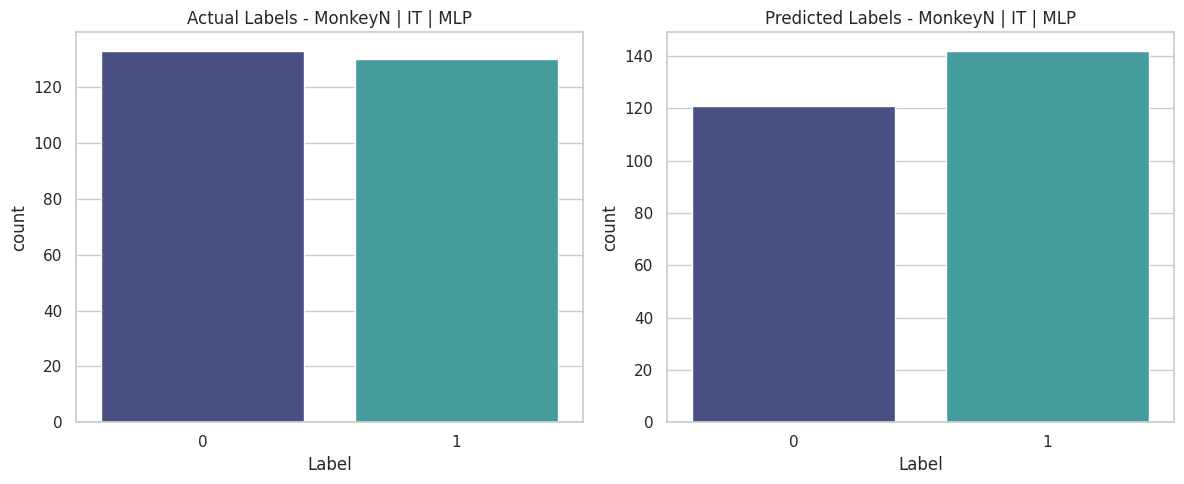

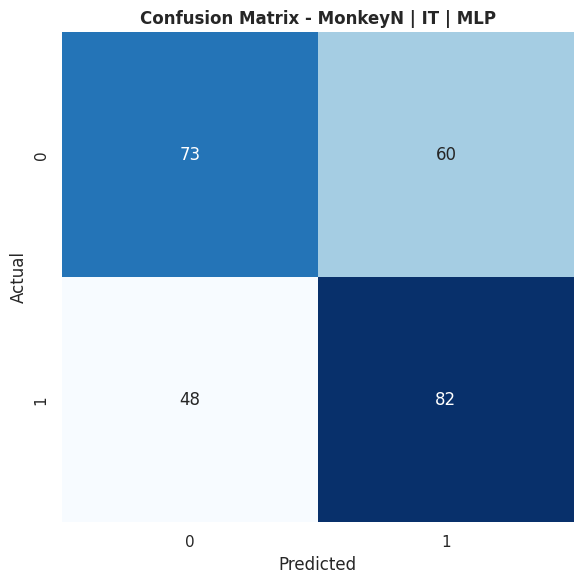

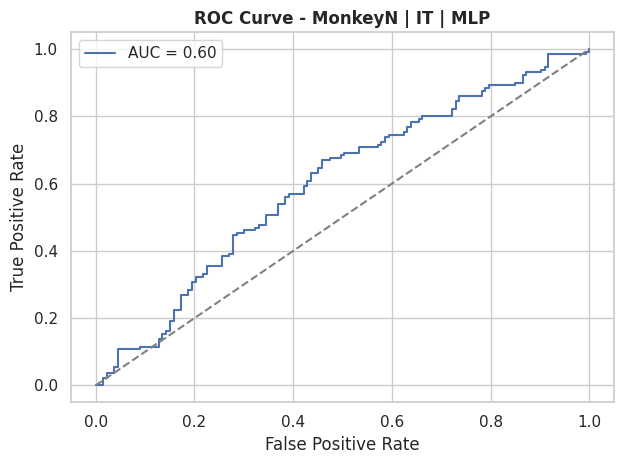

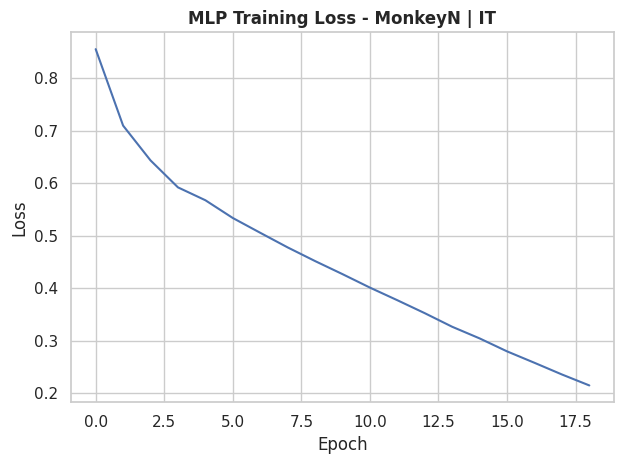


==== Processing ROI: All ====
PCA applied on 'All' ROI: reduced to 448 components.
Using fixed SVC parameters for ROI: All ...

[All | SVC] Model Performance:
Accuracy Score: 0.5057034220532319
Precision Score: 0.5
F1 Score: 0.057971014492753624
ROC AUC: 0.5222672064777327


<ipython-input-11-35c36c347725>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
<ipython-input-11-35c36c347725>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')


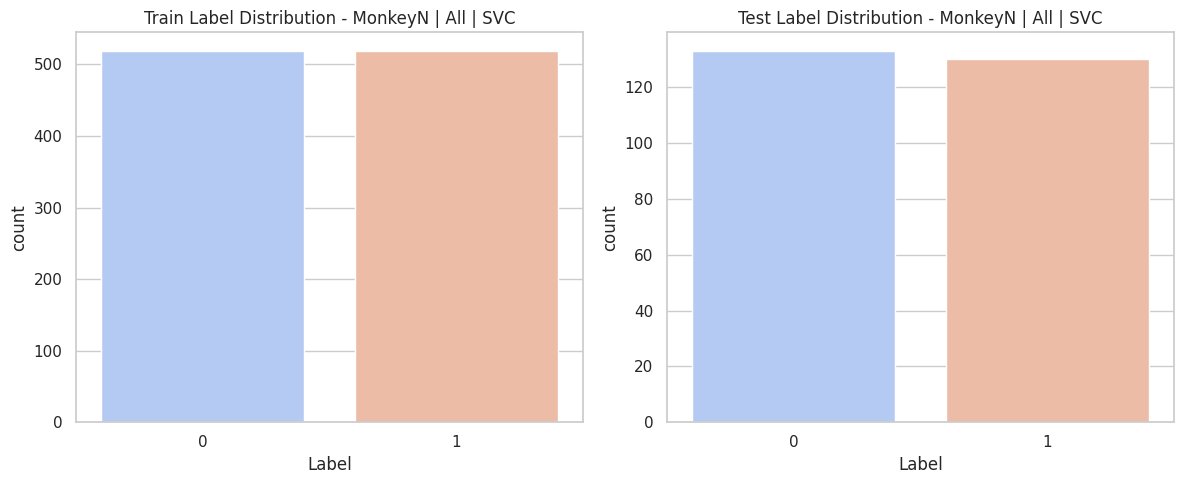

<ipython-input-11-35c36c347725>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
<ipython-input-11-35c36c347725>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')


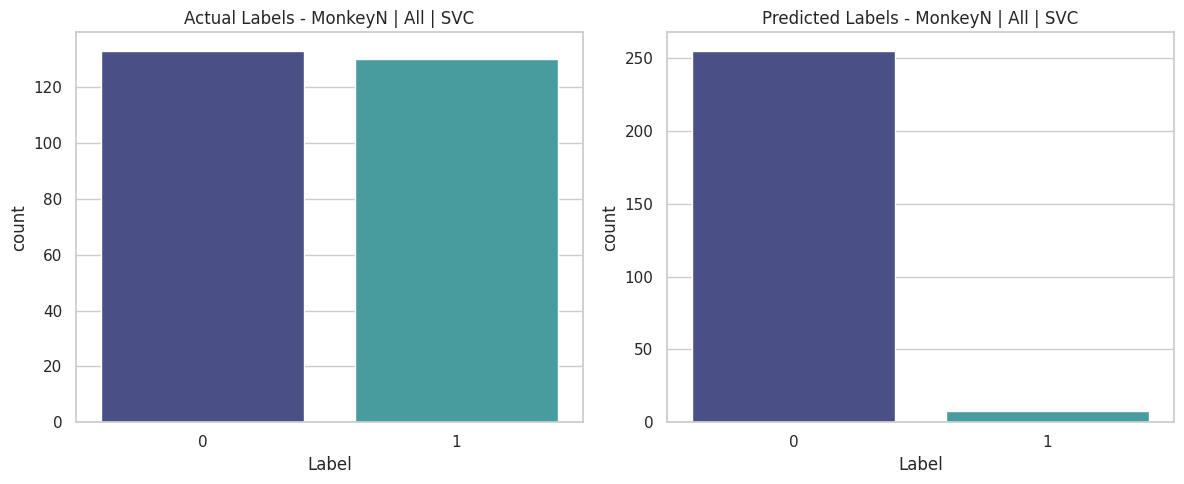

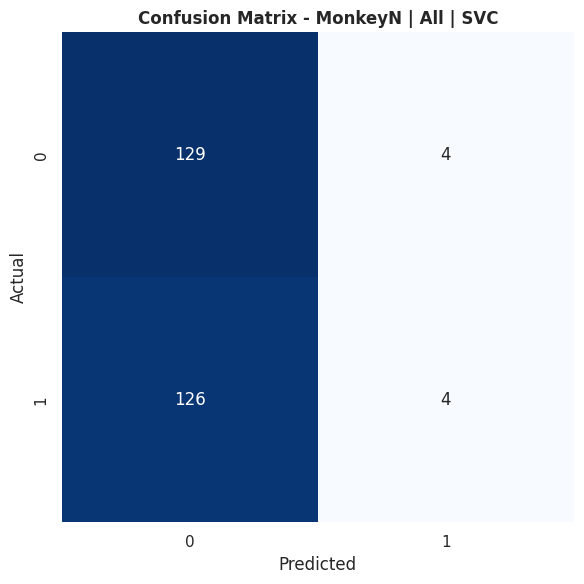

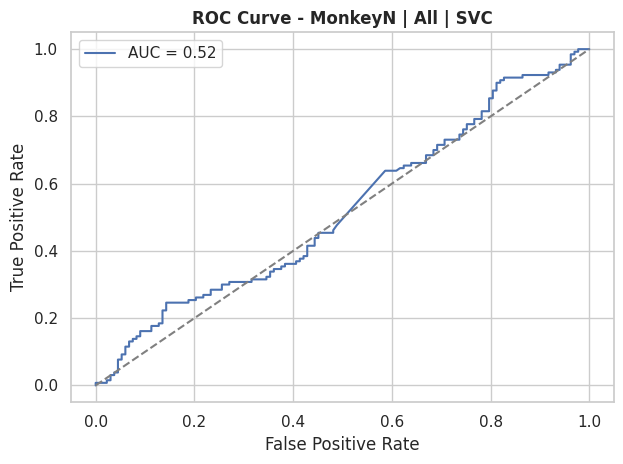


Training MLPClassifier for ROI: All ...

[All | MLP] Model Performance:
Accuracy Score: 0.5703422053231939
Precision Score: 0.5594405594405595
F1 Score: 0.5860805860805861
ROC AUC: 0.6023134759976865


<ipython-input-11-35c36c347725>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
<ipython-input-11-35c36c347725>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')


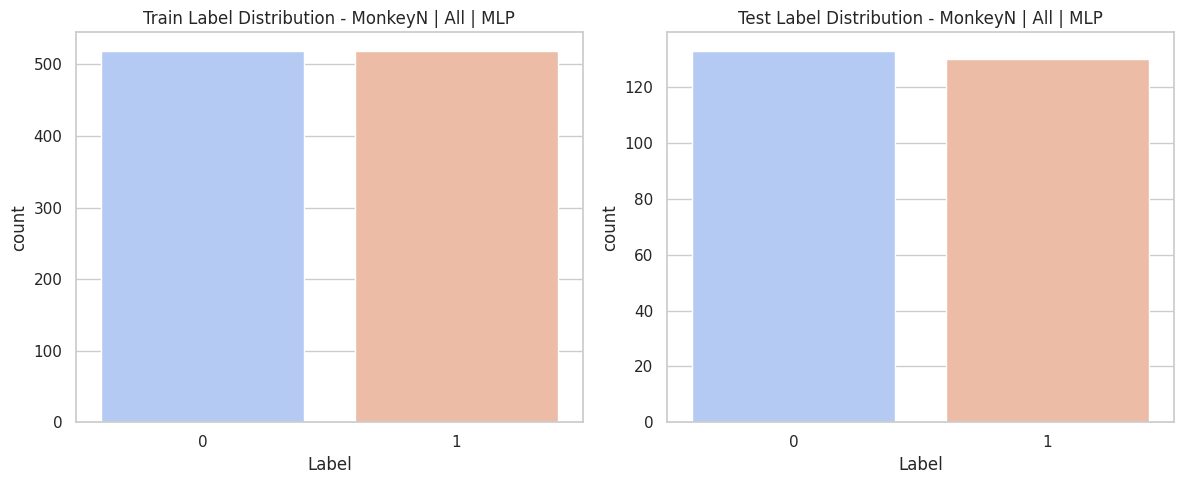

<ipython-input-11-35c36c347725>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
<ipython-input-11-35c36c347725>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')


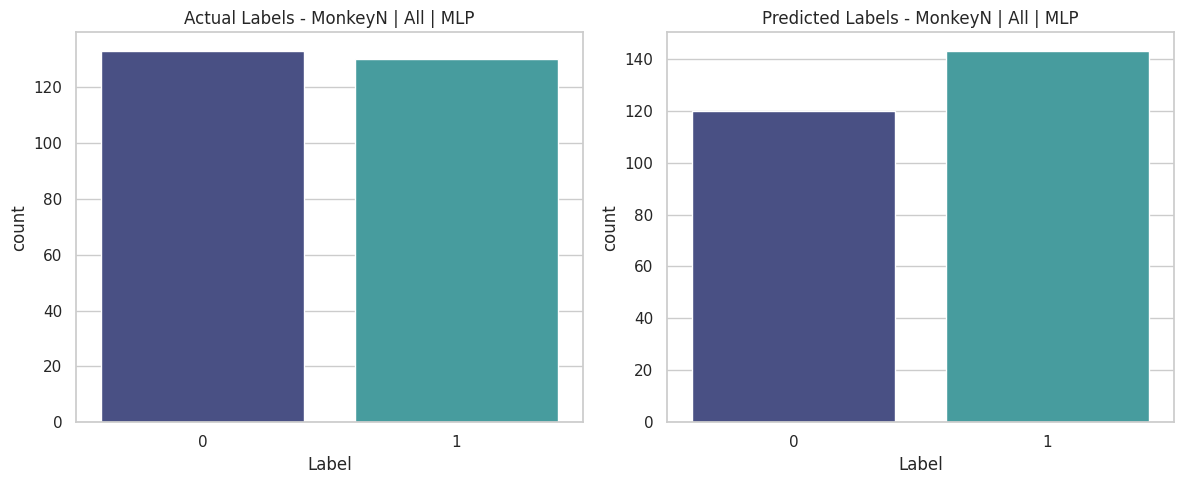

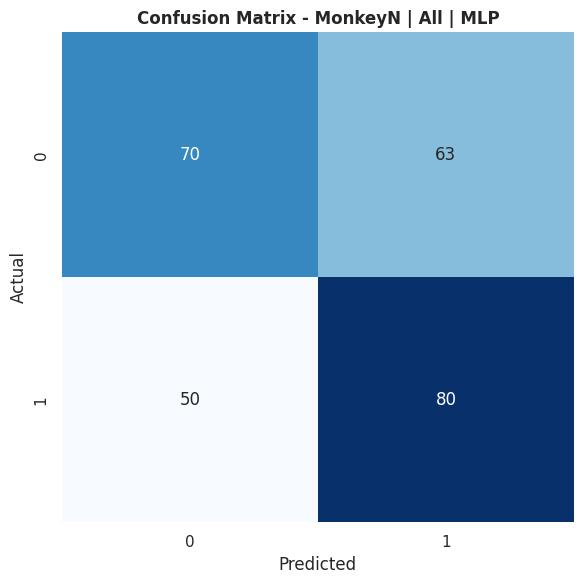

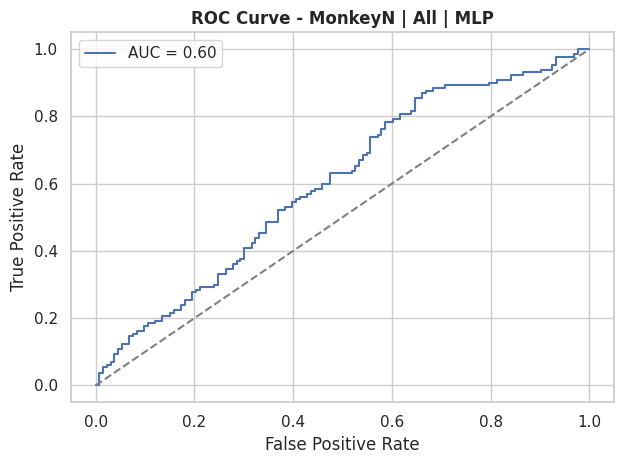

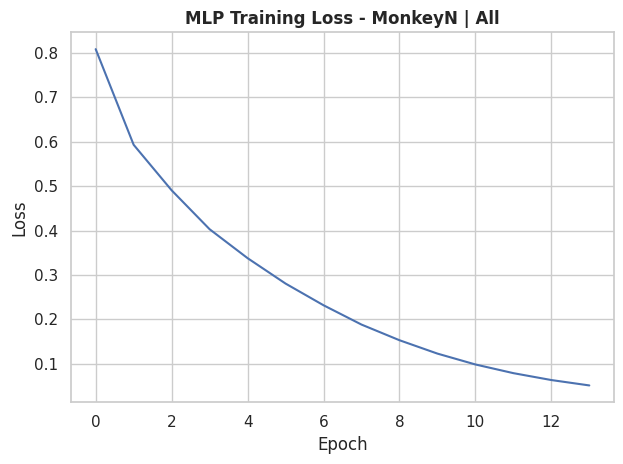

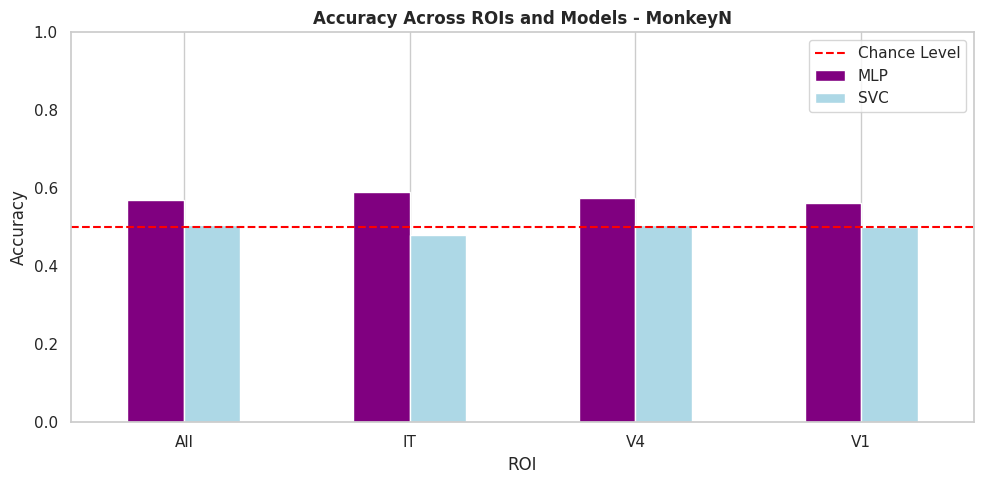

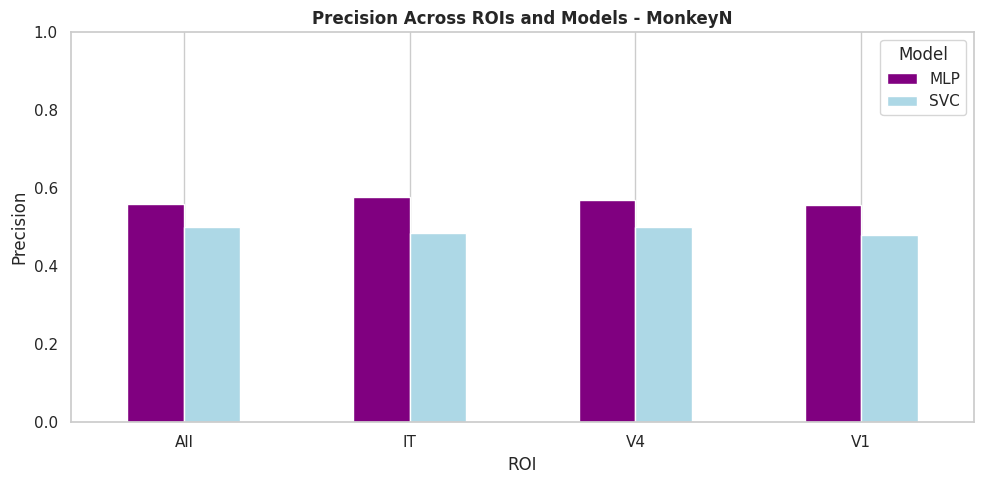

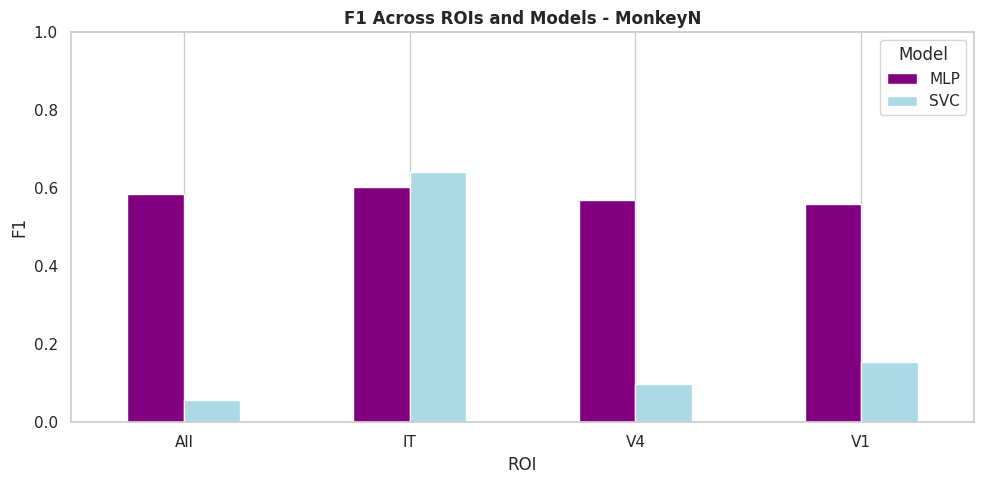

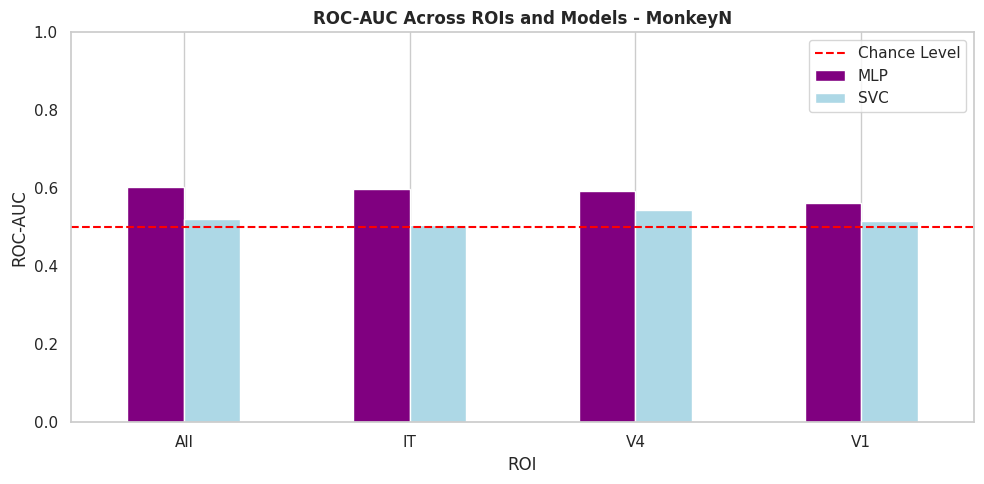

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    precision_score, accuracy_score, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, f1_score
)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from typing import Dict, List

use_grid_search = False  # Set to False to use fixed parameters
fixed_svc_params = {'kernel': 'rbf', 'C': 10, 'gamma': 0.1, 'probability': True, 'class_weight': 'balanced'}



def prepare_roi_electrodes(df: pd.DataFrame, roi_list: List[str]) -> Dict[str, List[str]]:
    """Create a dictionary mapping each ROI to its electrode columns."""
    roi_map = {
        roi: [
            col for col in df.columns
            if col.startswith("Electrode_") and not col.endswith("_Region") and df.loc[0, f"{col}_Region"] == roi
        ]
        for roi in roi_list
    }
    roi_map["All"] = [
        col for col in df.columns
        if col.startswith("Electrode_") and not col.endswith("_Region")
    ]
    return roi_map


def evaluate_model(
    X_train, y_train, X_test, y_test, model, model_name: str,
    roi: str, best_params: dict, results_summary: List[Dict],
    monkey_id: str
):
    """Train model, evaluate, and plot metrics with Seaborn visualizations."""

    model.fit(X_train, y_train)
    predicted_y = model.predict(X_test)

    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, predicted_y, zero_division=1)
    accuracy = accuracy_score(y_test, predicted_y)
    f1 = f1_score(y_test, predicted_y)
    roc_auc = roc_auc_score(y_test, y_scores)

    results_summary.append({
        "ROI": roi,
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "F1": f1,
        "ROC-AUC": roc_auc,
        "BestParams": best_params
    })

    print(f"\n[{roi} | {model_name}] Model Performance:")
    print("Accuracy Score:", accuracy)
    print("Precision Score:", precision)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)

    sns.set_theme(style="whitegrid")

    # Label distributions
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=pd.Series(y_train, name="Label"), palette='coolwarm')
    plt.title(f"Train Label Distribution - {monkey_id} | {roi} | {model_name}")

    plt.subplot(1, 2, 2)
    sns.countplot(x=pd.Series(y_test, name="Label"), palette='coolwarm')
    plt.title(f"Test Label Distribution - {monkey_id} | {roi} | {model_name}")
    plt.tight_layout()
    plt.show()

    # Actual vs Predicted
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=pd.Series(y_test, name="Label"), palette='mako')
    plt.title(f"Actual Labels - {monkey_id} | {roi} | {model_name}")

    plt.subplot(1, 2, 2)
    sns.countplot(x=pd.Series(predicted_y, name="Label"), palette='mako')
    plt.title(f"Predicted Labels - {monkey_id} | {roi} | {model_name}")
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, predicted_y)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {monkey_id} | {roi} | {model_name}", fontweight='bold')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {monkey_id} | {roi} | {model_name}', fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # MLP-specific: plot training loss
    if hasattr(model, "loss_curve_"):
        plt.figure()
        plt.plot(model.loss_curve_)
        plt.title(f"MLP Training Loss - {monkey_id} | {roi}", fontweight='bold')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



def plot_summary_metrics(results_df: pd.DataFrame):
    """Create summary bar plots for model metrics across ROIs in fixed order."""
    metrics = ["Accuracy", "Precision", "F1", "ROC-AUC"]
    roi_order = ["All", "IT", "V4", "V1"]

    # Define colors for models
    model_colors = {
        "SVC": "lightblue",
        "MLP": "purple"
    }

    for metric in metrics:
        pivoted = results_df.pivot(index="ROI", columns="Model", values=metric)
        pivoted = pivoted.reindex(roi_order)

        # Get color list for current model columns
        columns = pivoted.columns
        colors = [model_colors.get(model, "#cccccc") for model in columns]

        ax = pivoted.plot(kind='bar', rot=0, figsize=(10, 5), color=colors)
        ax.set_ylim(0,1)
        if metric in ["Accuracy", "ROC-AUC"]:  # Plot chance lvl line only where meaningful
          ax.axhline(0.5, color='red', linestyle='--', linewidth=1.5, label='Chance Level')
          ax.legend(loc='upper right')
        ax.set_title(f"{metric} Across ROIs and Models - {monkey_id}", fontweight='bold')
        ax.set_ylabel(metric)
        ax.set_xlabel("ROI")
        ax.grid(axis='y')
        plt.tight_layout()
        plt.show()


# --- Main execution ---
results_summary = []
roi_regions = prepare_roi_electrodes(df, roi_list=["V1", "V4", "IT"])

param_grid = {
    'C': [1, 10, 100],
    'gamma': [1e-3, 1e-4, 1e-5],
    'kernel': ['rbf']
}

for roi, electrode_cols in roi_regions.items():
    print(f"\n=== Processing ROI: {roi} ====")

    subset = df_balanced.dropna(subset=electrode_cols + ['memorability_class']).drop_duplicates(subset=['Stimulus_Name'])
    X = subset[electrode_cols]
    y = subset['memorability_class'].astype(int)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Optional PCA (ONLY for "All" ROI)
    if roi == "All":
        pca = PCA(n_components=0.95)  # Retain 95% of variance
        X_train_scaled = pca.fit_transform(X_train_scaled)
        X_test_scaled = pca.transform(X_test_scaled)
        print(f"PCA applied on 'All' ROI: reduced to {X_train_scaled.shape[1]} components.")

    # Undersample
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

    if use_grid_search:
        svc = SVC(probability=True, class_weight='balanced')
        grid_search = GridSearchCV(
            estimator=svc,
            param_grid=param_grid,
            cv=5,
            scoring='accuracy',
            verbose=0,
            n_jobs=-1
        )

        print(f"Running GridSearchCV for ROI: {roi} ...")
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {roi}: {best_params}")

        # Save full CV results
        cv_results_df = pd.DataFrame(grid_search.cv_results_)
        cv_results_df.to_csv(f"gridsearch_cv_results_{roi}.csv", index=False)

    else:
        print(f"Using fixed SVC parameters for ROI: {roi} ...")
        best_model = SVC(**fixed_svc_params)
        best_model.fit(X_train_resampled, y_train_resampled)
        best_params = fixed_svc_params

    # --- Evaluate Best SVC ---
    evaluate_model(
        X_train_resampled, y_train_resampled, X_test_scaled, y_test,
        best_model, "SVC", roi, best_params, results_summary, monkey_id
    )

    # --- Define and Evaluate MLP ---
    mlp = MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )

    print(f"\nTraining MLPClassifier for ROI: {roi} ...")
    mlp.fit(X_train_resampled, y_train_resampled)

    evaluate_model(
        X_train_resampled, y_train_resampled, X_test_scaled, y_test,
        mlp, "MLP", roi, {"hidden_layers": (128, 64)}, results_summary, monkey_id
    )


# --- Results Summary ---
results_df = pd.DataFrame(results_summary)
plot_summary_metrics(results_df)


# trying more complex MLP

Epoch 10/60, Loss: 0.6099
Epoch 20/60, Loss: 0.5088
Epoch 30/60, Loss: 0.3884
Epoch 40/60, Loss: 0.3386
Epoch 50/60, Loss: 0.3251
Epoch 60/60, Loss: 0.2390


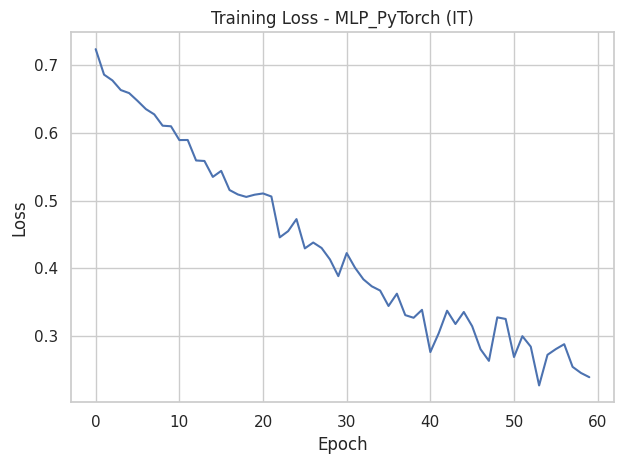

Test Accuracy : 0.5620253164556962
Test Precision: 0.5647058823529412


In [ ]:

# MLP Model

class MemorabilityMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.85),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.6),

            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            # nn.Dropout(0.1),


            nn.Linear(4, 1),
            nn.Sigmoid()  # Binary classification
        )

    def forward(self, x):
        return self.model(x)


# Main Pipeline

def main_mua_pipeline(df):
    # only IT electrodes, numeric columns, has 'cr'.
    df_prepped = prepare_monkey_df(df)

    # Filter Q1/Q3 extremes
    X_filtered, y_filtered = filter_extremes_q1_q3(df_prepped, mem_col="cr",
                                                   q1_percent=10, q3_percent=90)

    # Stratified Split
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in sss.split(X_filtered, y_filtered):
        X_train = X_filtered.iloc[train_index]
        X_test = X_filtered.iloc[test_index]
        y_train = y_filtered[train_index]
        y_test = y_filtered[test_index]

    print("Train label distribution:", np.bincount(y_train))
    print("Test label distribution :", np.bincount(y_test))
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

    # Standard Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)


    # Convert to Tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled,  dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

    # DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False)

    # Initialize Model
    input_dim = X_train_scaled.shape[1]
    model = MemorabilityMLP(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005/2) #weight_decay=1e-4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training
    num_epochs = 60
    train_loss_history = []  # Store average training loss per epoch
    test_loss_history = []   # Store average test loss per epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        batch_count = 0

        # Training Loop
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_count += 1

        # Compute & store average training loss
        avg_train_loss = running_loss / batch_count
        train_loss_history.append(avg_train_loss)

        # Compute & store test loss
        model.eval()
        test_running_loss = 0.0
        test_batch_count = 0

        with torch.no_grad():
            for X_t, y_t in test_loader:
                X_t, y_t = X_t.to(device), y_t.to(device)
                test_outputs = model(X_t)
                test_loss = criterion(test_outputs, y_t)
                test_running_loss += test_loss.item()
                test_batch_count += 1

        avg_test_loss = test_running_loss / test_batch_count
        test_loss_history.append(avg_test_loss)

        # Print loss every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_test_loss:.4f}")

    # After training, plot both loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.plot(range(1, num_epochs + 1), test_loss_history, marker='s', linestyle='--', color='g', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


    # Test Evaluation
    model.eval()
    with torch.no_grad():
        for X_t, y_t in test_loader:
            X_eval, y_eval = X_t.to(device), y_t.to(device)
        outputs = model(X_eval)
        predicted_classes = (outputs >= 0.5).float()

    predicted_classes_np = predicted_classes.cpu().numpy().flatten()
    y_test_np = y_eval.cpu().numpy().flatten()

    test_precision = precision_score(y_test_np, predicted_classes_np, zero_division=1)
    test_accuracy  = accuracy_score(y_test_np, predicted_classes_np)

    print("\nTest Predicted Class Distribution:", np.bincount(predicted_classes_np.astype(int)))
    print("Test Precision Score:", test_precision)
    print("Test Accuracy Score:", test_accuracy)

    # Evaluate on Train Set
    train_predictions = []
    train_targets = []
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float()
            train_predictions.append(preds.cpu().numpy())
            train_targets.append(y_batch.cpu().numpy())

    train_predictions = np.concatenate(train_predictions).ravel()
    train_targets     = np.concatenate(train_targets).ravel()

    train_precision = precision_score(train_targets, train_predictions, zero_division=1)
    train_accuracy  = accuracy_score(train_targets, train_predictions)

    print("\nTrain Predicted Class Distribution:", np.bincount(train_predictions.astype(int)))
    print("Train Precision Score:", train_precision)
    print("Train Accuracy Score:", train_accuracy)

    return model, train_predictions, train_targets, y_test_np, predicted_classes_np

Low Memorability: ≤ 0.682926829
High Memorability: ≥ 0.894736842
Train label distribution: [1644 1597]
Test label distribution : [704 685]
X_train shape: (3241, 260), X_test shape: (1389, 260)
Epoch 5/60, Train Loss: 0.6816, Validation Loss: 0.6825
Epoch 10/60, Train Loss: 0.6731, Validation Loss: 0.6611
Epoch 15/60, Train Loss: 0.6618, Validation Loss: 0.6498
Epoch 20/60, Train Loss: 0.6542, Validation Loss: 0.6443
Epoch 25/60, Train Loss: 0.6573, Validation Loss: 0.6425
Epoch 30/60, Train Loss: 0.6538, Validation Loss: 0.6435
Epoch 35/60, Train Loss: 0.6406, Validation Loss: 0.6357
Epoch 40/60, Train Loss: 0.6407, Validation Loss: 0.6400
Epoch 45/60, Train Loss: 0.6404, Validation Loss: 0.6388
Epoch 50/60, Train Loss: 0.6360, Validation Loss: 0.6385
Epoch 55/60, Train Loss: 0.6287, Validation Loss: 0.6362
Epoch 60/60, Train Loss: 0.6324, Validation Loss: 0.6364


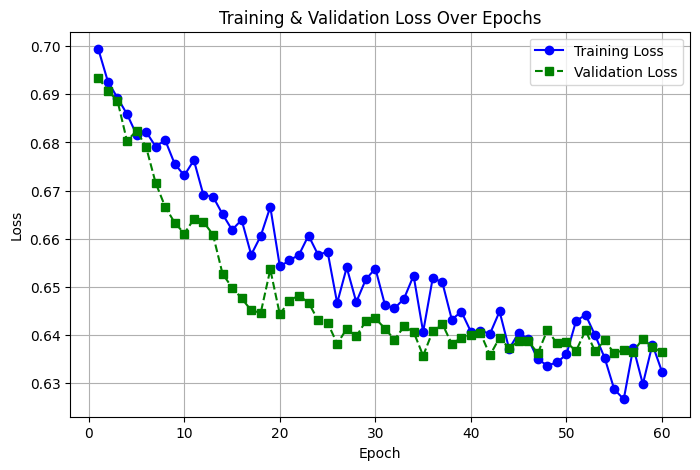


Test Predicted Class Distribution: [695 694]
Test Precision Score: 0.638328530259366
Test Accuracy Score: 0.6450683945284377

Train Predicted Class Distribution: [1694 1547]
Train Precision Score: 0.7123464770523594
Train Accuracy Score: 0.7099660598580685


In [ ]:
model, train_predictions, train_targets, y_test_np, predicted_classes_np = main_mua_pipeline(df)

#   - drops non-numeric columns
#   - applies Q1/Q3 filtering on 'cr' (memorability)